In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz
import os
import datetime
import numpy as np
import torch as th
from torch_geometric.loader import DenseDataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from classifier.data import CGDataset
from classifier.model import Diff_CG_Classifier, MinCut_CG_Classifier, DMoN_CG_Classifier
from classifier.train import pool_train_loop
from classifier.test import pool_test_loop

print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

#Training Set
import torch_geometric.transforms as T
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = CGDataset(training_dir, rmsd_list, vectorize, k, transform=T.ToDense(64))

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = CGDataset(val_dir, val_rmsd, vectorize, k, transform=T.ToDense(64))

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = CGDataset(test_dir, test_rmsd, vectorize, k, transform=T.ToDense(64))

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, vectorize, k, transform=T.ToDense(64))

#Rotated Test Sets
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = CGDataset(test_dir_rot, test_rmsd, vectorize, k, transform=T.ToDense(64))

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = CGDataset(fst_test_rot, st_test_rmsd, vectorize, k, transform=T.ToDense(64))

Pytorch Version 1.11.0
Cuda is available: True
Using device: cuda


TODO:
*  **Check why fewer graphs are loaded into the training dataset than are in the rmsd list**
*  Change data preparation so that s0 is always at [0, 0, 1, 0, y_e, 1] **DONE**
*  Add further that start of s1 is in xy-plane with s0
*  Use A-Minor Interactions as an additional edge for graph construction **DONE**
*  are there additional tertiary interactions detected to add?
*  Integrate (Root) Mean Squared Error, Mean Absolute Error or other Regression Related Metric **DONE** 
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  add link prediction loss and entropy regularization to the loss function **DONE**
*  which noramlization to use?

In [14]:
#Training
model = MinCut_CG_Classifier(training_dataset.num_node_features)

parent_dir = "run_data/"


#epoch_losses, val_losses, mae_losses, learning_rates, epoch_add_losses = 
pool_train_loop(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-3,
    epochs=200,
    sched_T0=200,
    vectorize=vectorize,
    k=k,
    burn_in=50)

Epoch 0: Training loss 10.7040, Validation loss 14.3787, learning rate 0.00100
		eadd_loss = -0.5459 vadd_loss = -0.5264
		Validation MAE: 15.3893
Epoch 5: Training loss 3.8641, Validation loss 13.9972, learning rate 0.00100
		eadd_loss = -0.5821 vadd_loss = -0.6100
		Validation MAE: 15.0678
Epoch 10: Training loss 2.6318, Validation loss 13.9738, learning rate 0.00100
		eadd_loss = -0.5414 vadd_loss = -0.5397
		Validation MAE: 14.9689


KeyboardInterrupt: 

In [3]:
#get training run data

run_dir = "pyg_model_data/2022-05-04_9-43_MinCut_CG_Classifier"

file_lines = []
with open(run_dir + "/loss_data.txt", "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]
epoch_add_losses = [float(d) for d in file_lines[4]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after 50 epochs) {min(val_losses[50:]):.4f} in epoch {val_losses.index(min(val_losses[50:]))}")
print(f"Minimum MAE (after 50 epochs) {min(mae_losses[50:]):.4f} in epoch {mae_losses.index(min(mae_losses[50:]))}")


Minimum Training Loss -0.4856 in epoch 202
Minimum Validation Loss (after 50 epochs) 12.9840 in epoch 654
Minimum MAE (after 50 epochs) 14.0389 in epoch 654


Validation Loss at 654 is 12.9840
5 before select
13.6907, 13.3987, 13.5486, 13.4517, 13.4421
5 after select
13.5891, 13.5993, 13.5597, 13.5116, 13.2018
MAE at 654 is 14.0389


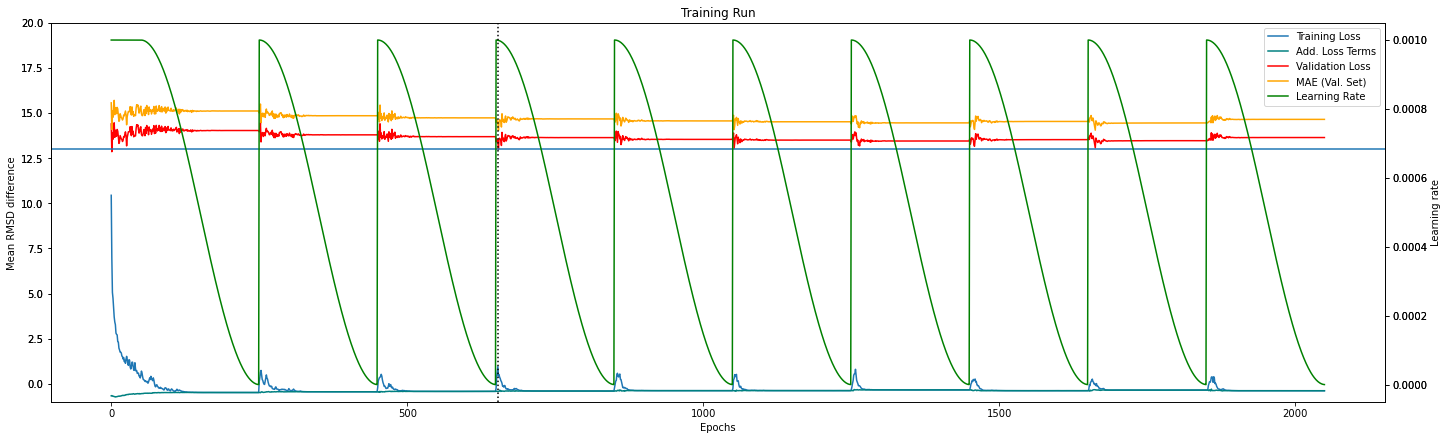

In [13]:
#plot the training run
select = 654
print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(epoch_add_losses, "teal", label="Add. Loss Terms")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")
ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=-1, upper=20)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=13)
han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2, loc="upper right")
plt.draw()

Test Set
tensor([[15.6720]], device='cuda:0') tensor([[15.5367]], device='cuda:0') 0.009158551692962646
tensor([[0.]], device='cuda:0') tensor([[28.9193]], device='cuda:0') 28.419315338134766
Mean Test loss: 	 11.3807
Std. Dev. of Test loss:  6.9067
Min loss: 		 0.0092
First Quantile: 	 5.9011
Median: 		 10.4583
Third Quantile: 	 17.5763
Max Loss: 		 28.4193
LinregressResult(slope=0.08879586657145089, intercept=15.011220893602985, rvalue=0.032766511336806206, pvalue=0.5871138192117535, stderr=0.16332886140979522, intercept_stderr=3.402647768682262)


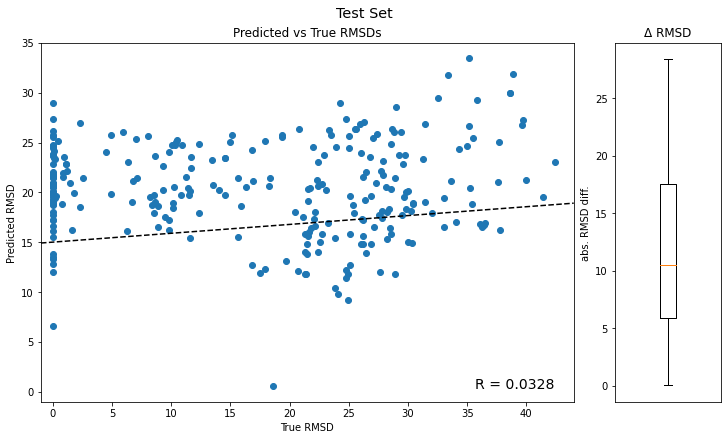

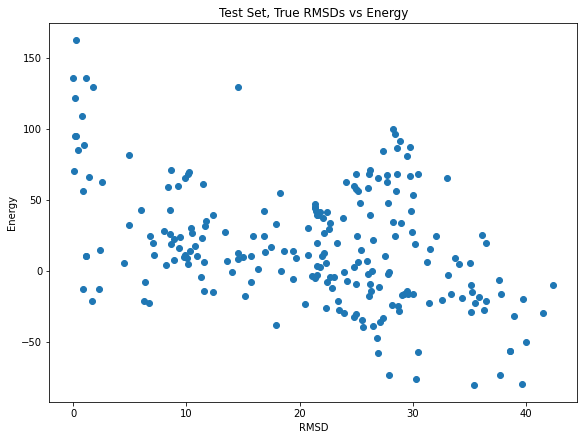

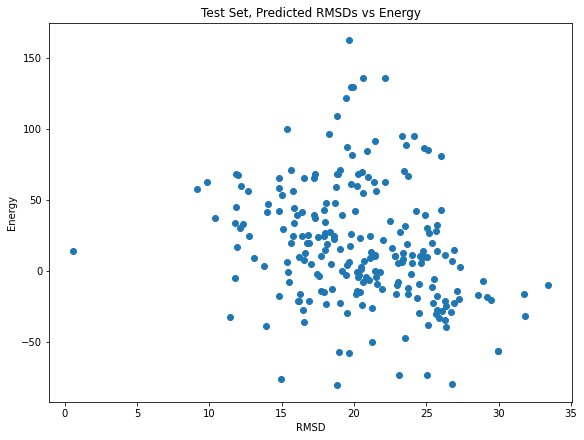

5S and tRNA Test Set
tensor([[8.8630]], device='cuda:0') tensor([[8.8804]], device='cuda:0') 0.00015165853255894035
tensor([[0.]], device='cuda:0') tensor([[26.8148]], device='cuda:0') 26.314775466918945
Mean Test loss: 	 4.0956
Std. Dev. of Test loss:  4.5506
Min loss: 		 0.0002
First Quantile: 	 1.0244
Median: 		 2.7064
Third Quantile: 	 5.3348
Max Loss: 		 26.3148
LinregressResult(slope=0.9169266612529957, intercept=-0.6848146495878762, rvalue=0.7344625633789043, pvalue=3.366919784621055e-184, stderr=0.025768992209020805, intercept_stderr=0.5010142562970665)


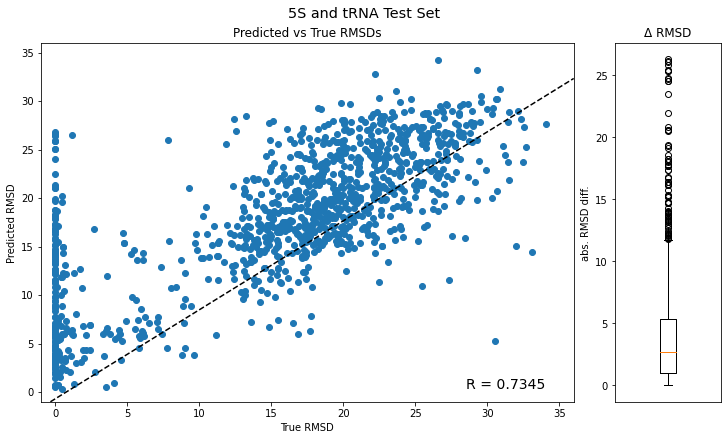

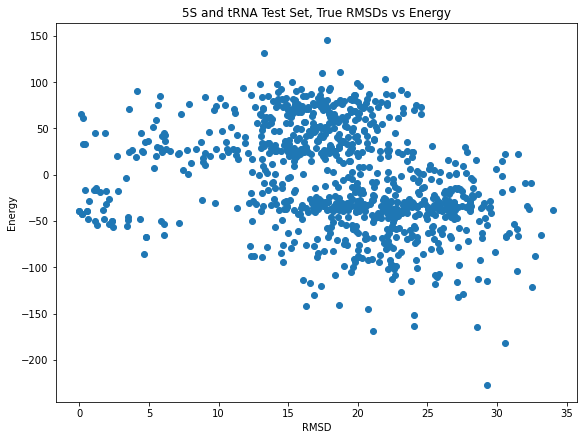

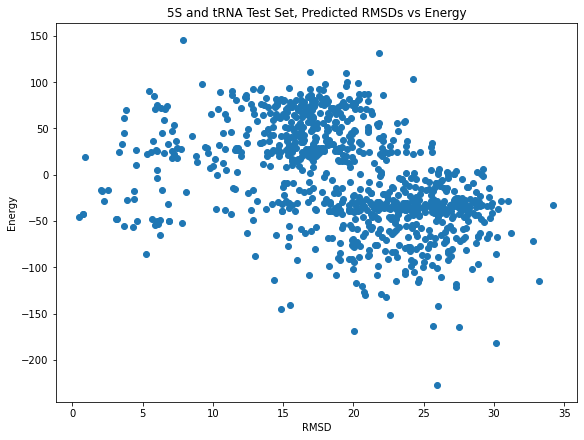

Training Set
tensor([[14.8520]], device='cuda:0') tensor([[14.8498]], device='cuda:0') 2.507069439161569e-06
tensor([[16.8550]], device='cuda:0') tensor([[21.8241]], device='cuda:0') 4.469089508056641
Mean Test loss: 	 0.2203
Std. Dev. of Test loss:  0.3748
Min loss: 		 0.0000
First Quantile: 	 0.0211
Median: 		 0.0774
Third Quantile: 	 0.2579
Max Loss: 		 4.4691
LinregressResult(slope=1.0045601875829437, intercept=-0.4132821579866395, rvalue=0.9976193687586795, pvalue=0.0, stderr=0.0025221965167589225, intercept_stderr=0.05140572133480201)


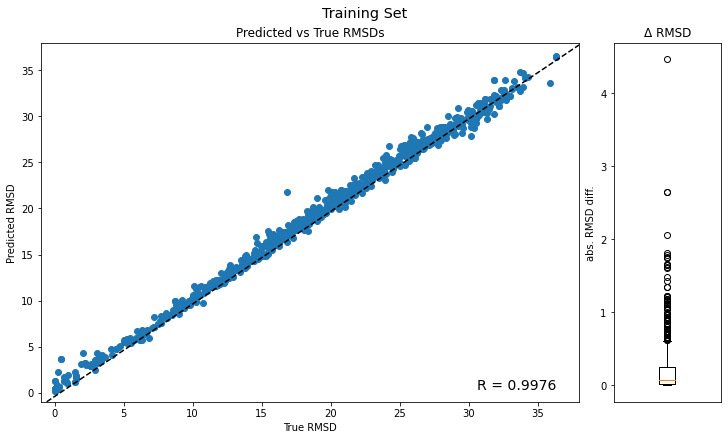

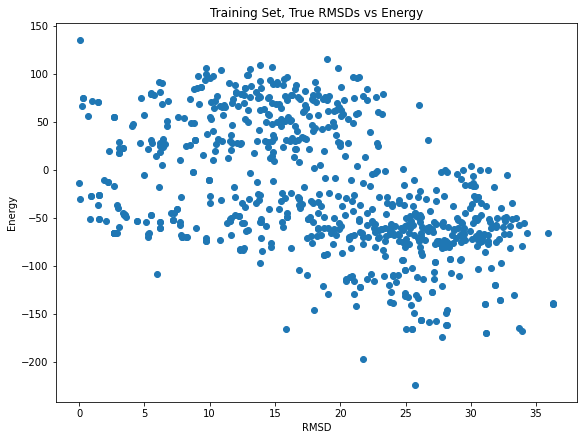

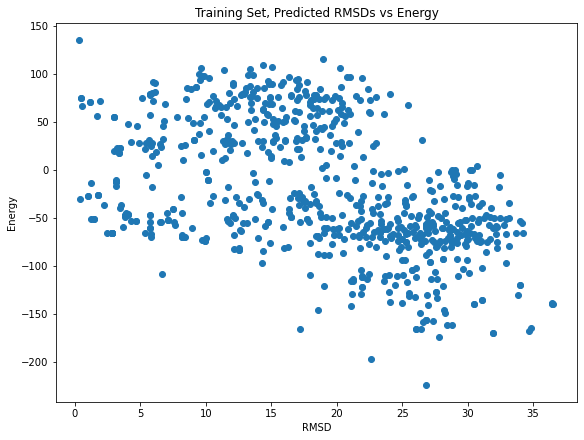

Validation Set
tensor([[14.5020]], device='cuda:0') tensor([[14.4848]], device='cuda:0') 0.00014874940097797662
tensor([[61.9850]], device='cuda:0') tensor([[15.7576]], device='cuda:0') 45.72735595703125
Mean Test loss: 	 13.5173
Std. Dev. of Test loss:  9.9455
Min loss: 		 0.0001
First Quantile: 	 4.9049
Median: 		 12.4695
Third Quantile: 	 20.2956
Max Loss: 		 45.7274
LinregressResult(slope=-0.025319861283401728, intercept=23.785806772413192, rvalue=-0.009038308068388411, pvalue=0.8577059505185753, stderr=0.14112642213790366, intercept_stderr=3.1194123748517537)


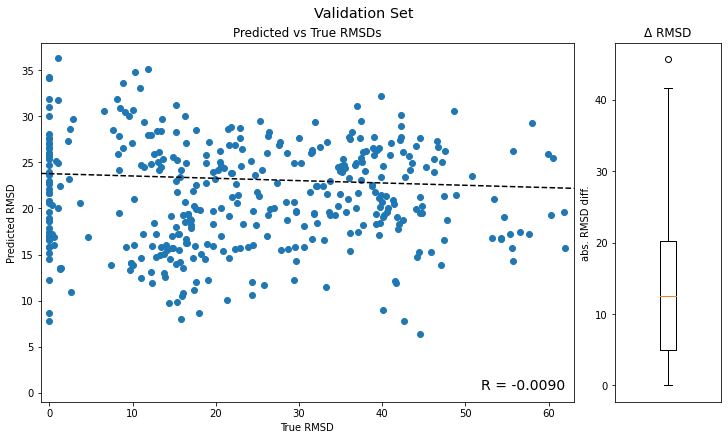

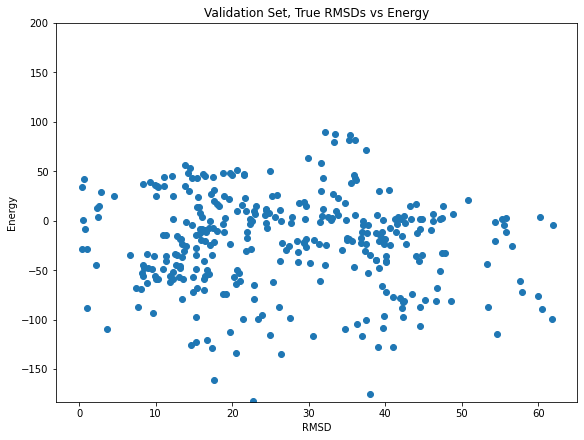

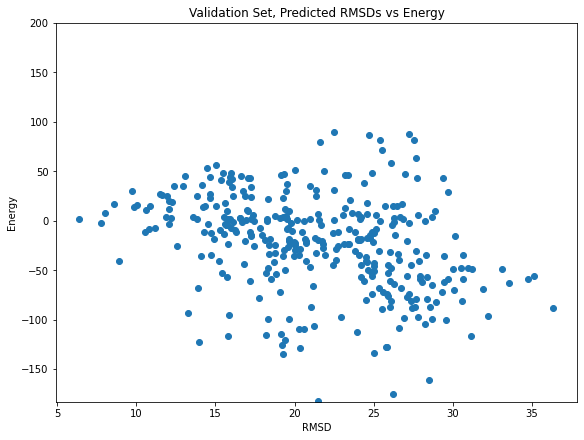

LinregressResult(slope=0.5994041948348827, intercept=8.822781588971493, rvalue=0.35282525165986356, pvalue=6.03720157247476e-45, stderr=0.04119498996833091, intercept_stderr=0.860160892856725)


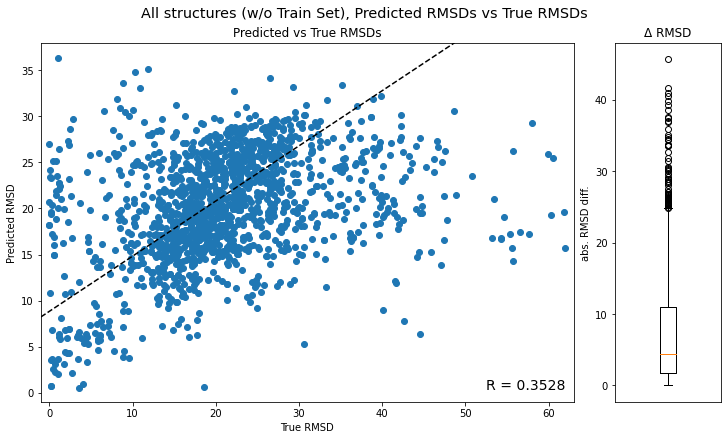

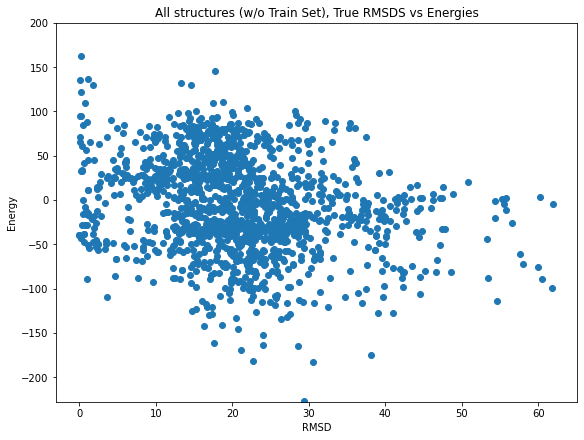

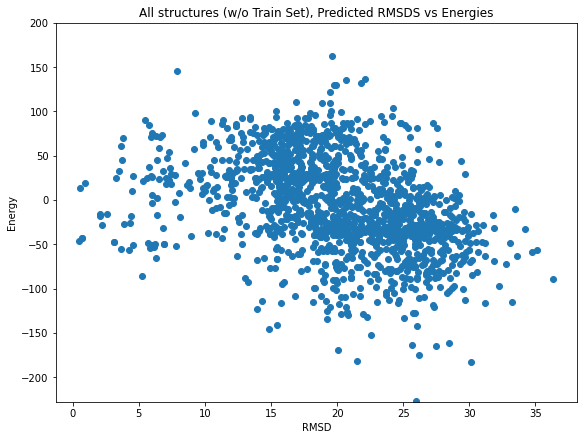

In [12]:
#Test
from pyg_classifier.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

if "model" not in globals():
    num_node_feats = training_dataset.num_node_features
    model = DMoN_CG_Classifier(num_node_feats).to(device)

train_loader = DenseDataLoader(training_dataset, batch_size=1)
val_loader = DenseDataLoader(val_dataset, batch_size=1)
test_dataloader = DenseDataLoader(test_dataset, batch_size=1)
st_test_dataloader = DenseDataLoader(st_test_dataset, batch_size=1)

model.to(device)
model.load_state_dict(th.load(f"{run_dir}/model_data/epoch_{select}.pth"))

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs, tlosses = pool_test_loop(model, loader, e_dict, title, device)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=0.9863135032756845, intercept=0.20749926050278944, rvalue=0.9811396690769674, pvalue=2.5347935986712346e-198, stderr=0.011717905683077727, intercept_stderr=0.2575486711893376)


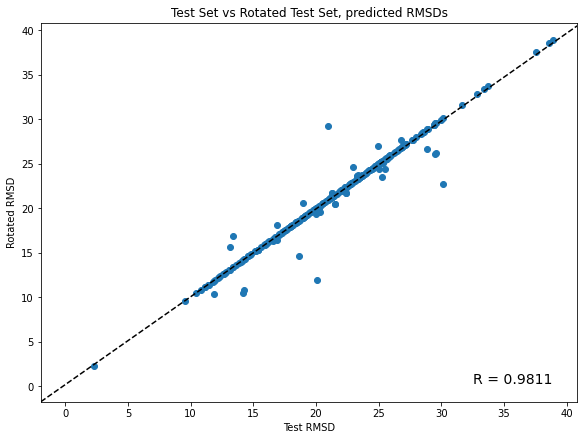

LinregressResult(slope=0.9796253411299547, intercept=0.15870407920892404, rvalue=0.9902744780469577, pvalue=1.332455106126599e-237, stderr=0.00829948270043615, intercept_stderr=0.11684619835347136)


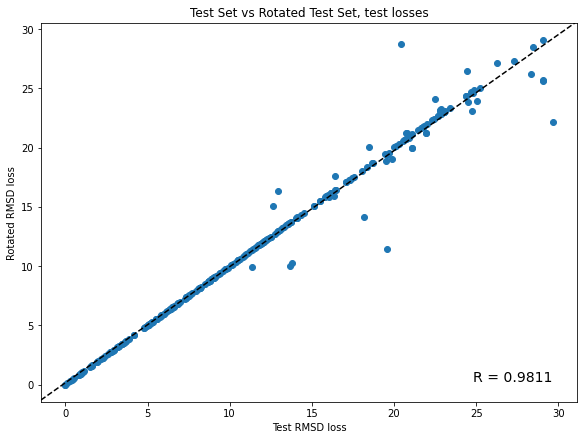

LinregressResult(slope=0.9627460958728602, intercept=0.7842855121692587, rvalue=0.9690947043008298, pvalue=0.0, stderr=0.007453880957320046, intercept_stderr=0.15165968400797167)


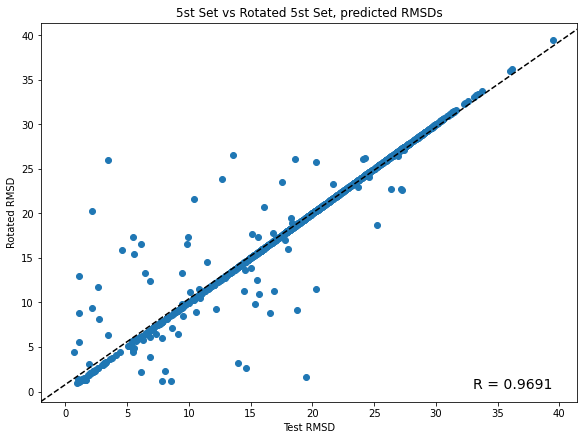

LinregressResult(slope=0.9576432858840295, intercept=0.26815094908713366, rvalue=0.9280323715919784, pvalue=0.0, stderr=0.011691050918618558, intercept_stderr=0.07648336501021415)


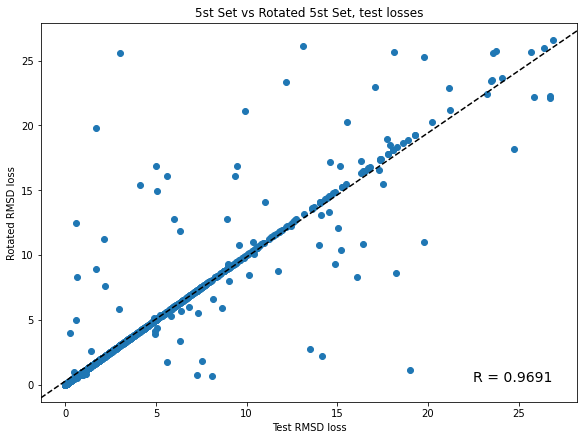

In [6]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DenseDataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DenseDataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")